In [1]:
%load_ext Cython

In [2]:
import numpy as np
from pprint import pprint
from numpy import array, zeros, diag, diagflat, dot
import timeit
from matplotlib import pyplot as plt
from scipy.sparse import diags
from matplotlib import pyplot as plt

In [3]:
import psutil, os
p = psutil.Process(os.getpid())
p.nice(psutil.HIGH_PRIORITY_CLASS)

In [4]:
def symmetric_array_n(n):
    main_diag = np.linspace(2, 2, num=n, dtype=np.int8)
    lowUp_diag = np.linspace(-1, -1, num = n-1, dtype=np.int8)
    diagonals = [main_diag, lowUp_diag, lowUp_diag]
    A = diags(diagonals, [0, -1, 1]).toarray()
    return A

### Jacobi

$$x_i^{(k)} = \frac{-\sum_{j=1_{j\ne i}}^{n}(a_{ij}x_j^{(k-1)}) +b_i}{a_{ii}} $$



In [5]:
def jacobi(A, b, P, tol=1.0e-3, max_iter=1000):

    if P is None:
        P = np.zeros(len(A[0]))
        
    N = len(b) 
    x = np.zeros(len(A[0]))
    
    for k in range(0, max_iter):
        for i in range(0, N):
            val = 0
            for j in range(0, i):                
                val += - (A[i, j]*P[j])
            for j in range(i+1, N):
                val += - (A[i, j]*P[j])
                    
            x[i] = (val + b[i])/A[i, i]
            
        err = np.abs(np.linalg.norm(x - P)) / np.abs((np.linalg.norm(x) + np.finfo(np.float).eps))
        P = x.copy()
        
        if(err < tol):
            return x
    return x

In [6]:
%%cython
cimport numpy as np
cimport cython
import numpy as np

@cython.boundscheck(False) # turn of bounds-checking for entire function

def jacobi_cython(np.ndarray[double, ndim=2] A, np.ndarray[double, ndim=1] b, np.ndarray[double, ndim=1]  P, double tol=1.0e-3, int max_iter=1000):

    cdef int N = len(b)
    cdef np.ndarray x = np.zeros(len(A[0]))
    cdef unsigned int k, i, j
    cdef double val, err, relerr
    
    if P is None:
        P = np.zeros(len(A[0]))
    
    for k in range(0, max_iter):
        for i in range(0, N):
            val = 0
            for j in range(0, i):                
                val += - (A[i, j]*P[j])
            for j in range(i+1, N):
                val += - (A[i, j]*P[j])
                    
            x[i] = (val + b[i])/A[i, i]
            
        err = np.abs(np.linalg.norm(x - P)) /  np.abs((np.linalg.norm(x) + np.finfo(np.float).eps))
        P = x.copy()
        
        if(err < tol):
            return x
    return x

### Gauss-Seidel

$$x_i^{(k)} = \frac{-\sum_{j=1}^{i-1}(a_{ij}x_j^{(k)}) - \sum_{j=i+1}^{n}(a_{ij}x_j^{(k-1)}) +b_i}{a_{ii}}$$



In [7]:
def gauss_seidel(A, b, P, tol=1.0e-3, max_iter=1000):
    if P is None:
        P = np.zeros(len(A[0]))
    
    N = len(b)
    x = np.zeros(len(A[0]))
    
    for k in range(0, max_iter):
        for i in range(0, N):
            val = 0
            for j in range(0, i):
                val += - (A[i, j]*x[j])
            for j in range(i+1, N):
                val += - (A[i, j]*P[j])
                    
            x[i] = (val + b[i])/A[i, i]
                
        err = np.abs(np.linalg.norm(x - P))/ np.abs((np.linalg.norm(x) + np.finfo(np.float).eps))
        P = x.copy()
        
        if(err < tol):
            return x
    return x

In [8]:
%%cython
cimport numpy as np
cimport cython
import numpy as np

@cython.boundscheck(False) # turn of bounds-checking for entire function
def gauss_seidel_cython(np.ndarray[double, ndim=2] A, np.ndarray[double, ndim=1] b, np.ndarray[double, ndim=1] P, double tol=1.0e-3, int max_iter=1000):

    cdef int N = len(b)
    cdef np.ndarray x = np.zeros(len(A[0]), dtype=np.float64)
    cdef unsigned int k, i, j
    cdef double val, err, relerr
    
    if P is None:
        P = np.zeros(len(A[0]))
    
    for k in range(0, max_iter):
        for i in range(0, N):
            val = 0                          
            for j in range(0, i):
                val += - (A[i, j]*x[j])
            for j in range(i+1, N):
                val += - (A[i, j]*P[j])
                
            x[i] = (val + b[i])/A[i, i]
                
        err = np.abs(np.linalg.norm(x - P))/ np.abs((np.linalg.norm(x) + np.finfo(np.float).eps))
        P = x.copy()
        
        if(err < tol):
            return x
    return x

### SOR

$$x_i^{(k)} = (1-\omega)x_i^{(k-1)} + \frac{\omega}{a_{ii}}[b_i - \sum_{j=1}^{i-1}a_{ij}x_j^{(k)} - \sum_{j+i+1}^n a_{ij}x_j^{(k-1)}] $$



In [9]:
def SOR(A, b, P, w, tol=1.0e-3, max_iter=1000):

    if P is None:
        P = np.zeros(len(A[0]))
        
    if w is None:
        w = 1.0
    
    N = len(b)
    x = np.zeros(len(A[0]))
    
    for k in range(0, max_iter):
        for i in range(0, N):
            val = 0
            for j in range(0, N):                
                if j < i:
                    val += - (A[i, j]*x[j])
                if j > i:
                    val += - (A[i, j]*P[j])
            x[i] = (1-w)*P[i] + w*(val + b[i])/A[i, i]
                
        err = np.abs(np.linalg.norm(x - P)) / np.abs((np.linalg.norm(x) + np.finfo(np.float).eps))
        P = x.copy()
        
        if(err < tol):
            return x
    return x

In [10]:
%%cython

cimport numpy as np
cimport cython
import numpy as np

@cython.boundscheck(False) # turn of bounds-checking for entire functio

def SOR_cython(np.ndarray[double, ndim=2] A, np.ndarray[double, ndim=1] b, np.ndarray[double, ndim=1] P, double w, double tol=1.0e-3, int max_iter=1000):
    
    if P is None:
        P = np.zeros(len(A[0]), dtype=np.float64)
        
    if w is None:
        w = 1.0
    
    cdef int N = len(b)
    cdef np.ndarray x = np.zeros(len(A[0]), dtype=np.float64)
    cdef unsigned int k, i, j
    cdef double val, err
    
    for k in range(0, max_iter):
        for i in range(0, N):
            val = 0
            for j in range(0, N):                
                if j < i:
                    val += - (A[i, j]*x[j])
                if j > i:
                    val += - (A[i, j]*P[j])
                    
            x[i] = (1-w)*P[i] + w*(val + b[i])/A[i, i]
                
        err = np.abs(np.linalg.norm(x - P)) / np.abs((np.linalg.norm(x) + np.finfo(np.float).eps)) 
        P = x.copy()
        
        if(err < tol):
            return x
    return x

In [13]:
def conjugate_gradient(A, b, x=None, max_iter=1000, tol=1.0e-3):
    timer = time.time()
    
    if x is None:
        x = np.matrix(np.zeros(len(A[0]))).transpose()
        
    r0 = b - np.dot(A, x)
    p = r0

#   Start iterations    
    for i in xrange(max_iter):
        a = float(np.dot(r0.T, r0)/np.dot(np.dot(p.T, A), p))
        x = x + p*a
        ri = r0 - np.dot(A*a, p)

        if np.linalg.norm(ri) < tol:
            timer = time.time() - timer
            return x, timer
        b = float(np.dot(ri.T, ri)/np.dot(r0.T, r0))
        p = ri + b * p
        r0 = ri
    timer = time.time() - timer
    return x, timer

In [21]:
def test_algorithms(A, b, P, w, max_iter=1000, graph=True):

    print"Jacobi"
    jac = %timeit -o jacobi(A, b, None)
    print"Jacobi Cython"
    jac_cy = %timeit -o jacobi_cython(A, b, None)
    print 


    print"Gauss-Seidel"
    gau_sei = %timeit -o gauss_seidel(A, b, None)
    print"Gauss-Seidel Cython"
    gau_sei_cy = %timeit -o gauss_seidel_cython(A, b, None)
    print 

    print"SOR"
    sor = %timeit -o SOR(A, b, None, 1.25)
    print"SOR Cython"
    sor_cy = %timeit -o SOR_cython(A, b, None, 1.25)

    if graph:
        python = [jac.worst, gau_sei.worst, sor.worst]
        cython = [jac_cy.worst, gau_sei_cy.worst, sor_cy.worst]

        ind = np.arange(3)  # the x locations for the groups
        width = 0.35       # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(ind, python, width, color='r')

        rects2 = ax.bar(ind + width, cython, width, color='b')

        # add some text for labels, title and axes ticks
        ax.set_ylabel('Runtime (s)')
        ax.set_title('Python vs Cython')
        ax.set_xticks(ind + width)
        ax.set_xticklabels(('Jacobi', 'Gauss-Seidel', 'SOR'))

        ax.legend((rects1[0], rects2[0]), ('Python', 'Cython'))

        plt.grid()
        plt.show()
    return

In [15]:
A = symmetric_array_n(10)
b = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])

In [16]:
#Two Point Boundary Value Problem
def f(x):
    return -24.0*x**2

Jacobi
100 loops, best of 3: 7.06 ms per loop
Jacobi Cython
1000 loops, best of 3: 1.66 ms per loop

Gauss-Seidel
100 loops, best of 3: 4.25 ms per loop
Gauss-Seidel Cython
1000 loops, best of 3: 1.75 ms per loop

SOR
100 loops, best of 3: 3.03 ms per loop
SOR Cython
1000 loops, best of 3: 1.19 ms per loop


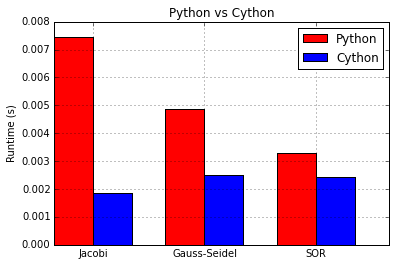

In [22]:
%matplotlib inline

n = 9
A = symmetric_array_n(n)
x = np.arange(1.0/(n+1), 1, 1.0/(n+1))
b = np.array(f(x)*(-1.0/n+1)**2)
b[0] = b[0] + 1
b = b.transpose()

test_algorithms(A, b, None, 1.25, graph=True)

Jacobi
1 loops, best of 3: 4.34 s per loop
Jacobi Cython
10 loops, best of 3: 29.2 ms per loop

Gauss-Seidel
1 loops, best of 3: 3.81 s per loop
Gauss-Seidel Cython
1 loops, best of 3: 1.23 s per loop

SOR
1 loops, best of 3: 3.59 s per loop
SOR Cython
1 loops, best of 3: 1.07 s per loop


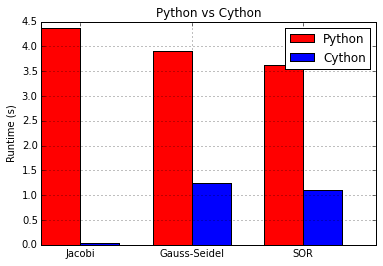

In [23]:
%matplotlib inline

n = 99
A = symmetric_array_n(n)
x = np.arange(1.0/(n+1), 1, 1.0/(n+1))
b = np.array(f(x)*(-1.0/n+1)**2)
b[0] = b[0] + 1
b = b.transpose()

test_algorithms(A, b, None, 1.25, graph=True)

In [29]:
%matplotlib inline

n = 9
A = symmetric_array_n(n)
x = np.arange(1.0/(n+1), 1, 1.0/(n+1))
b = np.array(f(x)*(-1.0/n+1)**2)
b[0] = b[0] + 1
b = b.transpose()

In [34]:
#Jacobi Solution Check

sol_1 = jacobi(A, b, None)
sol_2 = jacobi_cython(A, b, None)

print sol_1
print sol_2

[-14.32426667 -29.49868714 -43.99551538 -56.88983148 -66.88101533
 -72.26020085 -70.94366196 -60.43942627 -37.87982126]
[-14.32426667 -29.49868714 -43.99551538 -56.88983148 -66.88101533
 -72.26020085 -70.94366196 -60.43942627 -37.87982126]


In [35]:
#Gauss-Seidel Solution Check
sol_1 = gauss_seidel(A, b, None)
sol_2 = gauss_seidel_cython(A, b, None)


print sol_1
print sol_2

[-14.50040561 -29.85778882 -44.51766321 -57.53908186 -67.59463738
 -72.97114955 -71.5709093  -60.9133071  -38.13665355]
[-14.50040561 -29.85778882 -44.51766321 -57.53908186 -67.59463738
 -72.97114955 -71.5709093  -60.9133071  -38.13665355]


In [36]:
#SOR Solution Check

sol_1 = SOR(A, b, None, 1.25)
sol_2 = SOR_cython(A, b, None, 1.25)

print sol_1
print sol_2

[-14.60180408 -30.05077252 -44.78232317 -57.84794462 -67.91598417
 -73.27268435 -71.82332758 -61.09336081 -38.22939455]
[-14.60180408 -30.05077252 -44.78232317 -57.84794462 -67.91598417
 -73.27268435 -71.82332758 -61.09336081 -38.22939455]
